# Постановка задачи



# Импорты

In [1]:
# Системные импорты и настройки
import os
import sys
import yaml
import warnings
import ipynbname
import logging.config

warnings.filterwarnings('ignore')

# for local development
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

# read config
with open('config.yaml', "r") as stream:
    config = yaml.safe_load(stream)
    
# set logging config
log_config = config.get("log", None)
logging.config.dictConfig(log_config)

# set notebook alias
ALIAS = ipynbname.name()
print(ALIAS)

g10.3-RealData-05.2-REWARD_SCALE_CLOSE=500-gamma 0.99


In [2]:
# DS frameworks
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

%matplotlib notebook

In [3]:
# NN Frameworks
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Concatenate
from tensorflow.keras.layers import Conv1D, MaxPool1D, AveragePooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.models import load_model, clone_model

In [4]:
# RT packages
from rl import DQN
from env import TradeEnv

from core import RTCore
from core.context import BasicContext
from core.tickers import TickerExtendedReward
from core.observation_builder import ObservationBuilderOrderbook
from core.observation_builder.precompute import PrecomputeOrderbookDiffFeature

from data_point import DataPointFactory
from train_tools import Player, plot_and_go, AgentTrainWrapper

# Датасет

<IPython.core.display.Javascript object>


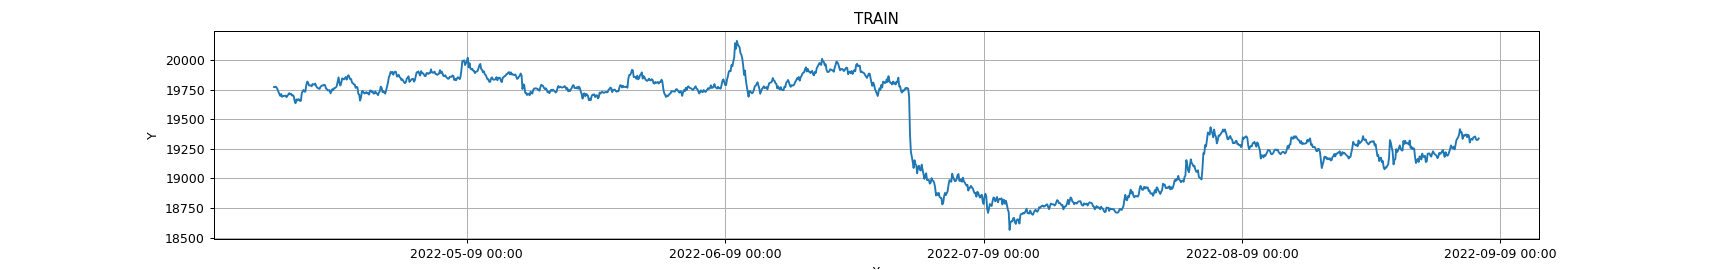

(1344, 11)


<IPython.core.display.Javascript object>


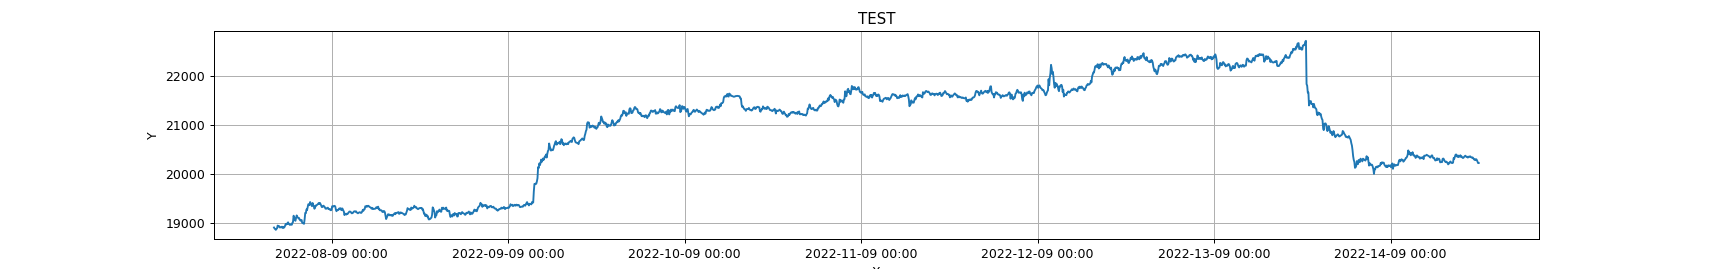

(1967, 11)


In [47]:
path_train = "../datasets/rt5/03.BTC_USDT-300-train.csv"
path_test = "../datasets/rt5/03.BTC_USDT-300-test.csv"


data_train = pd.read_csv(path_train, index_col='ts')
data_test = pd.read_csv(path_test, index_col='ts')



# todo связать history_size и step_factor
history_size = 360

# trim history
#data_train = data_train.iloc[history_size:]
#data_test = data_test.iloc[history_size:]

plot_and_go(data_train, title="TRAIN", fig_x=19, fig_y=3, dpi=50)
plot_and_go(data_test, title="TEST", fig_x=19, fig_y=3, dpi=50)

In [6]:
po = PrecomputeOrderbookDiffFeature()
orderbook_levels = (0.001, 0.0025, 0.005, 0.0075)

for level in orderbook_levels:
    data_train = po.process(data_train, level)
    data_test = po.process(data_test, level)


<IPython.core.display.Javascript object>


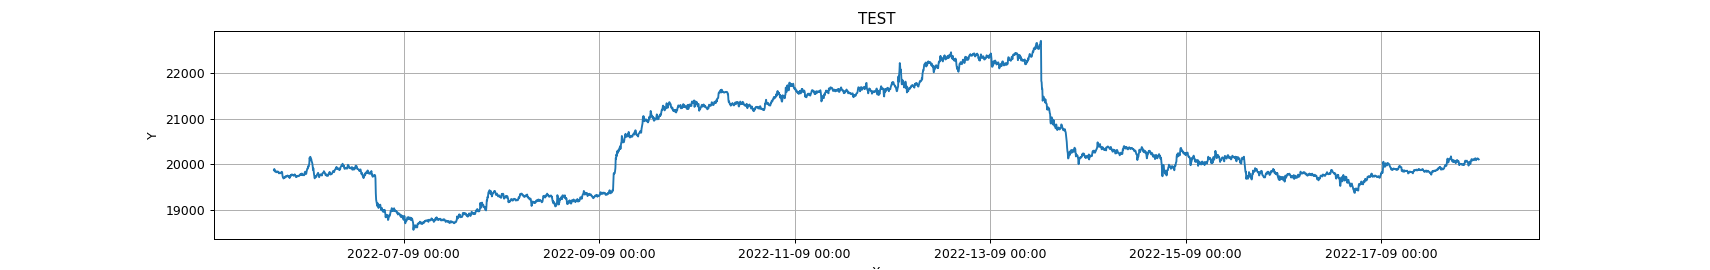

(3551, 11)


<IPython.core.display.Javascript object>


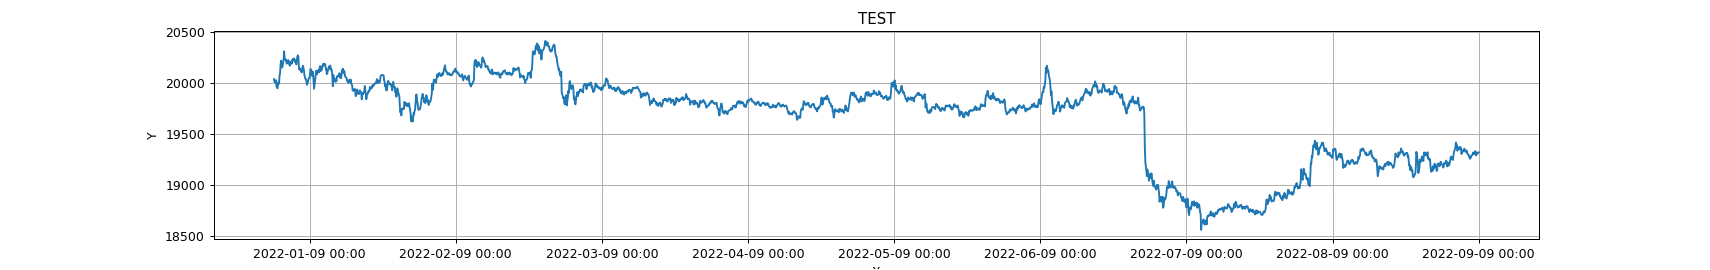

(2375, 11)


In [50]:
path_test2 = "../datasets/rt5/04.BTC_USDT-300-train.csv"
path_test3 = "../datasets/rt5/04.BTC_USDT-300-test.csv"
data_test2 = pd.read_csv(path_test2, index_col='ts')
data_test3 = pd.read_csv(path_test3, index_col='ts')

plot_and_go(data_test2, title="TEST", fig_x=19, fig_y=3, dpi=50)
plot_and_go(data_test3, title="TEST", fig_x=19, fig_y=3, dpi=50)


for level in orderbook_levels:
    data_test2 = po.process(data_test2, level)
    data_test3 = po.process(data_test3, level)
    
dpf_test2 = DataPointFactory(dataset=data_test2, **params)
dpf_test3 = DataPointFactory(dataset=data_test3, **params)

In [7]:
params = {
    "period": 300,                      # Интервал между точками наблюдения в сэмпле. При значении 300 берутся 5-ти минутные срезы.
    "n_observation_points": 30,         # Количество точек наблюдения в сэмпле
    "n_history_points": history_size,   # Количество точек наблюдения в сэмпле
    "n_future_points": 0,               # Количество будущех точек для предсказания тренда (временное решение)
    "step_size": 300                    # Шаг по датасету
 }

dpf_train = DataPointFactory(dataset=data_train, **params)
dpf_test = DataPointFactory(dataset=data_test, **params)

# Env

In [8]:
# Core setup
penalty = -2
reward = 0
market_fee = 0.0015

context = BasicContext(market_fee=market_fee)

action_controller = TickerExtendedReward(context, penalty=penalty, reward=reward)
action_controller.REWARD_SCALE_WAIT = 100
action_controller.REWARD_SCALE_OPEN = 10
action_controller.REWARD_SCALE_CLOSE = 500
action_controller.NUM_MEAN_OBS = 2

# todo переделать step_factor - сейчас неявно указывается количество 5-минутных интервалов
observation_builder = ObservationBuilderOrderbook(context, step_factor=[1, 3, 12], levels=orderbook_levels)

env_core = RTCore(context, action_controller, observation_builder)

# train environment
env = TradeEnv(env_core, dpf_train, alias=ALIAS)

# Нейронная сеть

In [9]:
ACTIVATION = 'relu'
def create_q_model(env):
    num_actions = env.action_space
    #----------------------------------------------
    
    inp_static = Input(shape=env.observation_space[0])
    
    inp_timesteps = Input(shape=env.observation_space[1])
    conv_ts = Conv1D(filters=16, kernel_size=7, strides=1, input_shape=env.observation_space[1], activation=ACTIVATION)(inp_timesteps)
    conv_ts = Conv1D(filters=32, kernel_size=5, strides=1, activation=ACTIVATION)(conv_ts)    
    conv_ts = MaxPool1D(pool_size=2)(conv_ts)
    flt_ts = Flatten()(conv_ts)
    
    classif = Concatenate()([inp_static, flt_ts])

    classif = Dense(512, activation=ACTIVATION)(classif)
    classif = Dense(64, activation=ACTIVATION)(classif)
    
    #classif = Dropout(0.3)(classif)

    output = Dense(num_actions, activation='softmax')(classif)

    model = Model(inputs=[inp_static, inp_timesteps], outputs=output)
    return model
model = create_q_model(env)
model_target = create_q_model(env)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 8)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 24, 16)       912         ['input_2[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 20, 32)       2592        ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 10, 32)       0           ['conv1d_1[0][0]']               
                                                                                              

2022-09-20 16:27:22.392580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Параметры DQN

In [10]:
num_of_episodes = 100
frames_per_episode = data_train.shape[0] - history_size - params["n_observation_points"] + 1
total_steps = frames_per_episode * 100

print("One episode requires {0} frames.\nSet {1} frames for one scene ({2} episodes).".format(frames_per_episode, total_steps, num_of_episodes))

One episode requires 955 frames.
Set 95500 frames for one scene (100 episodes).


In [11]:
epsilon_greedy_frames = total_steps #100000# 97700
epsilon_min = 0.03
#==========================================================

epsilon_random_frames = int(0.05 * epsilon_greedy_frames)
max_memory_length = int(0.2 * epsilon_greedy_frames)

update_target_network = int(0.01 * epsilon_greedy_frames)

#==========================================================
dqn_conf = {
    "gamma"      : 0.99,                    # Discount factor for past rewards
    "epsilon_min": epsilon_min,             # Minimum epsilon greedy parameter
    "epsilon_max": 1.0,                     # Maximum epsilon greedy parameter
    "epsilon"    : 1.0,                     # Minimum epsilon greedy parameter
    "max_steps_per_episode": 10000,
    "batch_size" : 32,                      # Size of batch taken from replay buffer
    
    "optimizer": tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.),
    "loss_function": tf.keras.losses.Huber(),
    #"loss_function": tf.keras.losses.CategoricalCrossentropy(),
    
    "epsilon_random_frames": epsilon_random_frames,
    "epsilon_greedy_frames": epsilon_greedy_frames,
    "max_memory_length"    : max_memory_length,
    "update_after_actions" : 4,
    "update_target_network": update_target_network,
    
}

# Train

<IPython.core.display.Javascript object>


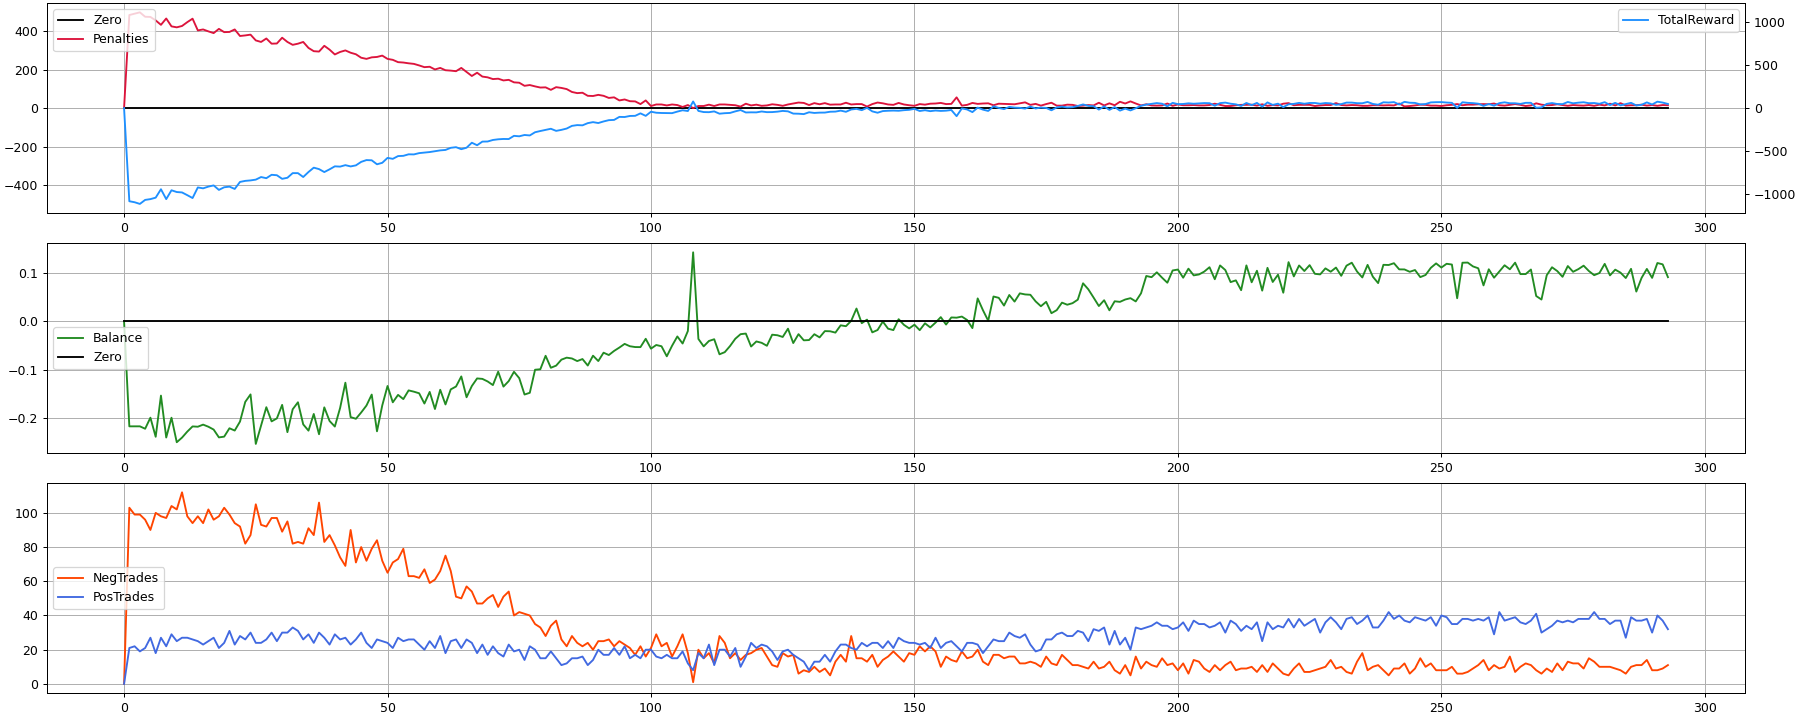

In [12]:
%matplotlib notebook

model = create_q_model(env)
model_target = create_q_model(env)

env.live_train_plot.init_plot(fig_size_x=20, fig_size_y=8, dpi=50, update=1)

agent = DQN(env, model, model_target, dqn_conf)

In [13]:
start, finish, step = 0.95, 3, 0.05
test_frames = [int(epsilon_greedy_frames * i) for i in np.arange(start, finish+step*0.99, step) ]
print("Test frames range:\n{}".format(str(test_frames)))

train_agent_wrapper = AgentTrainWrapper(agent, env_core, dpf_test)

Test frames range:
[90725, 95500, 100275, 105050, 109825, 114600, 119375, 124150, 128925, 133700, 138475, 143250, 148025, 152800, 157575, 162350, 167125, 171900, 176675, 181450, 186225, 191000, 195775, 200550, 205325, 210100, 214875, 219650, 224425, 229200, 233975, 238750, 243525, 248300, 253075, 257850, 262625, 267400, 272175, 276950, 281725, 286500]


In [19]:
#agent.train(max_frames=200000, goal_reward=20000)
train_agent_wrapper.train(test_frames)

Test frames: [105050 109825 114600 119375 124150 128925 133700 138475 143250 148025
 152800 157575 162350 167125 171900 176675 181450 186225 191000 195775
 200550 205325 210100 214875 219650 224425 229200 233975 238750 243525
 248300 253075 257850 262625 267400 272175 276950 281725 286500]
17:53:32 (  5 sec) | reward: -91.93 at episode 104, frame count 102185, epsilon: 0.03, loss:0.11
17:54:27 ( 55 sec) | reward: -84.86 at episode 105, frame count 103140, epsilon: 0.03, loss:0.11
17:55:26 ( 58 sec) | reward: -79.03 at episode 106, frame count 104095, epsilon: 0.03, loss:0.11
17:56:21 ( 55 sec) | reward: -72.74 at episode 107, frame count 105050, epsilon: 0.03, loss:0.11
Frame 105904 was reached!
TEST | balance: 0.0272, reward 21.428, penalties: 0, trades: 15 | 12 
17:57:52 (  6 sec) | reward: -66.93 at episode 107, frame count 106005, epsilon: 0.03, loss:0.09
17:58:49 ( 56 sec) | reward: -63.18 at episode 108, frame count 106960, epsilon: 0.03, loss:0.10
17:59:44 ( 55 sec) | reward: -5

Frame 167914 was reached!
TEST | balance: 0.0000, reward -3037.074, penalties: 1521, trades: 0 | 0 
19:05:11 (  9 sec) | reward: -8.39 at episode 159, frame count 168080, epsilon: 0.03, loss:0.07
19:06:05 ( 54 sec) | reward: -2.85 at episode 160, frame count 169035, epsilon: 0.03, loss:0.08
19:07:04 ( 58 sec) | reward: -2.29 at episode 161, frame count 169990, epsilon: 0.03, loss:0.07
19:08:02 ( 57 sec) | reward: -0.95 at episode 162, frame count 170945, epsilon: 0.03, loss:0.07
19:08:57 ( 55 sec) | reward:  2.59 at episode 163, frame count 171900, epsilon: 0.03, loss:0.08
Frame 172684 was reached!
TEST | balance: 0.0939, reward 69.277, penalties: 0, trades: 20 | 5 
19:10:28 ( 10 sec) | reward:  4.44 at episode 163, frame count 172855, epsilon: 0.03, loss:0.09
19:11:26 ( 57 sec) | reward:  6.61 at episode 164, frame count 173810, epsilon: 0.03, loss:0.08
19:12:21 ( 55 sec) | reward:  9.37 at episode 165, frame count 174765, epsilon: 0.03, loss:0.08
19:13:17 ( 55 sec) | reward:  7.47 at

20:19:04 ( 54 sec) | reward: 56.81 at episode 216, frame count 235885, epsilon: 0.03, loss:0.07
20:20:01 ( 57 sec) | reward: 57.49 at episode 217, frame count 236840, epsilon: 0.03, loss:0.07
20:20:57 ( 55 sec) | reward: 59.07 at episode 218, frame count 237795, epsilon: 0.03, loss:0.07
20:21:52 ( 55 sec) | reward: 59.99 at episode 219, frame count 238750, epsilon: 0.03, loss:0.06
Frame 239464 was reached!
TEST | balance: 0.1303, reward 70.919, penalties: 0, trades: 16 | 4 
20:23:25 ( 15 sec) | reward: 59.85 at episode 219, frame count 239705, epsilon: 0.03, loss:0.06
20:24:22 ( 57 sec) | reward: 56.82 at episode 220, frame count 240660, epsilon: 0.03, loss:0.07
20:25:18 ( 55 sec) | reward: 57.37 at episode 221, frame count 241615, epsilon: 0.03, loss:0.06
20:26:14 ( 55 sec) | reward: 57.60 at episode 222, frame count 242570, epsilon: 0.03, loss:0.06
20:27:10 ( 56 sec) | reward: 56.90 at episode 223, frame count 243525, epsilon: 0.03, loss:0.05
Frame 244234 was reached!
TEST | balance:


KeyboardInterrupt



<IPython.core.display.Javascript object>


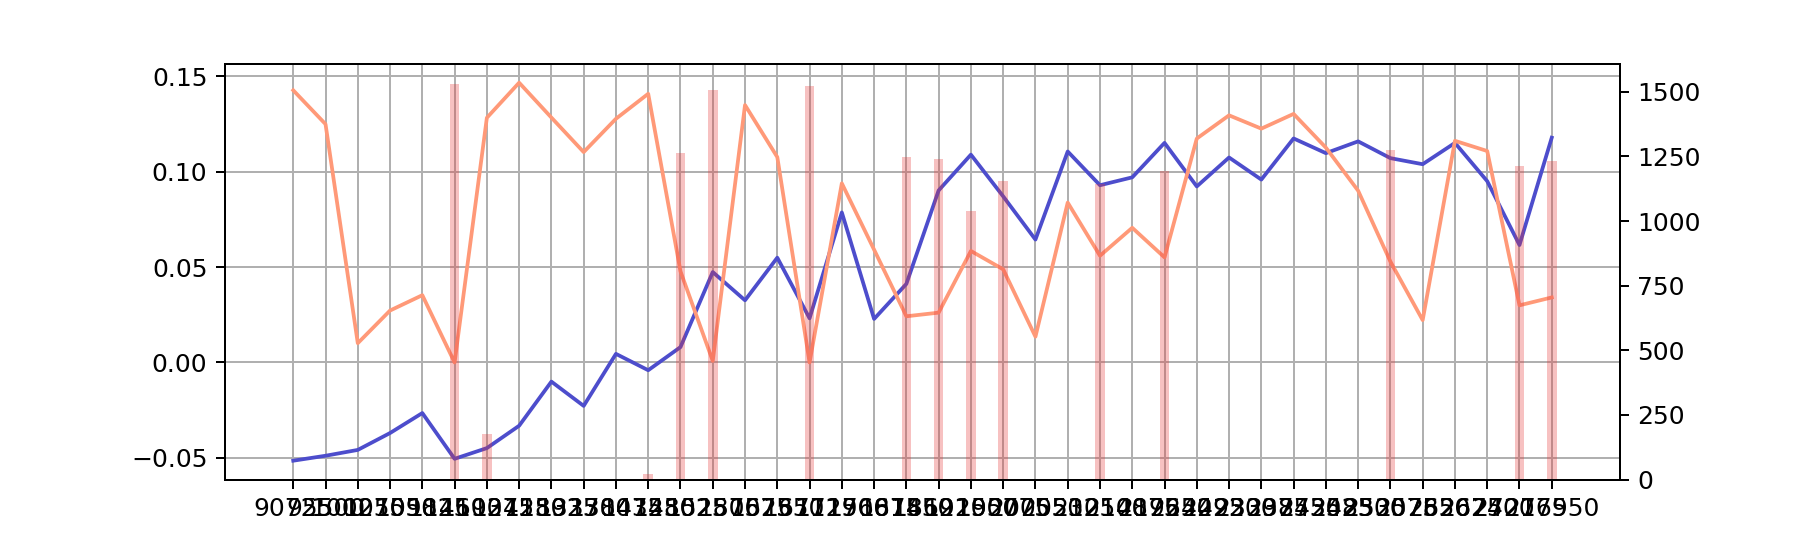

In [20]:
def plot_train_results(results):
    y_test = [row["test"]["Balance"] for row in results]
    y_test_penalties = [row["test"]["Penalties"] for row in results]
    y_train = [row["train"]["Balance"] for row in results]
    x_data = [str(row["frame"]) for row in results]
    fig, ax = plt.subplots(figsize = (10,3))
    ax2 = ax.twinx()
    ax.plot(x_data, y_train, color=(0.3,0.3,0.8))
    
    ax.plot(x_data, y_test, color=(1,0.6,0.47))
    ax2.bar(x=x_data, height=y_test_penalties, color=(0.9, 0.2, 0.2), alpha=0.3, width=0.3)
    
    ax.grid()
    
plot_train_results(train_agent_wrapper.results)

In [36]:
agent.model.save('models/model_' + ALIAS)

Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


# Test

In [42]:
#model_test = tf.keras.models.load_model('models/model_' + ALIAS)
#model_test.compile()

model_test = train_agent_wrapper.results[-3]["model"]

<IPython.core.display.Javascript object>


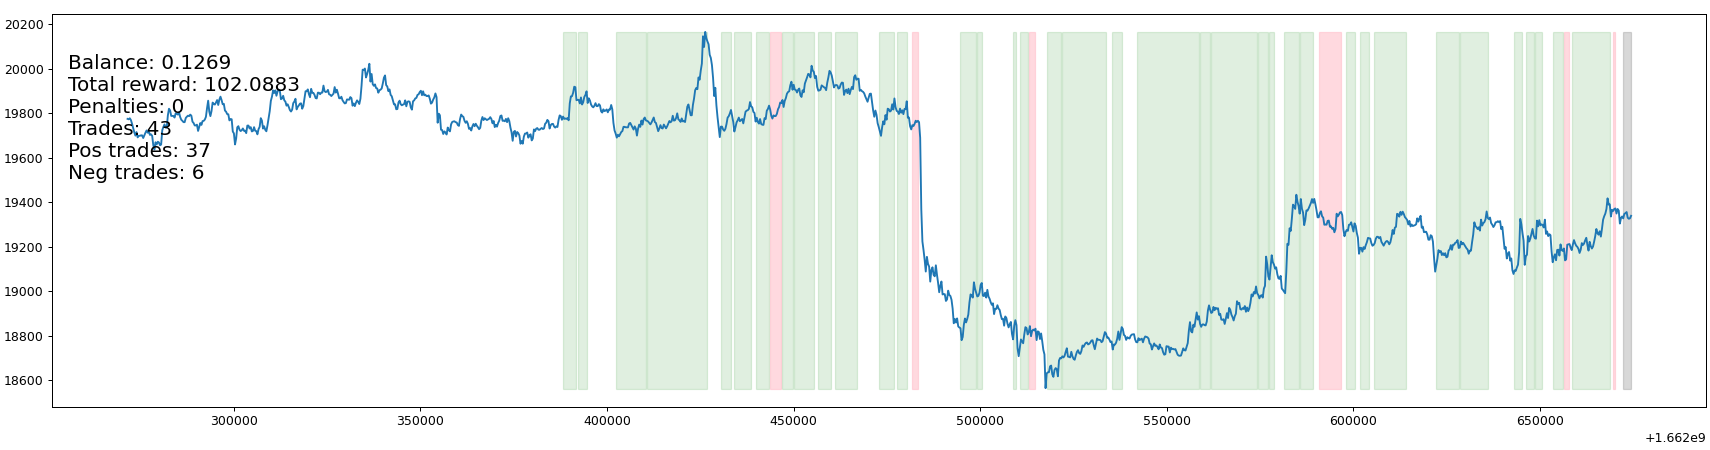

In [43]:
player = Player(env_core, model_test, dpf_train)
result = player.play(fig_size_x = 19, fig_size_y = 5, dpi = 50, font_size = 16)

<IPython.core.display.Javascript object>


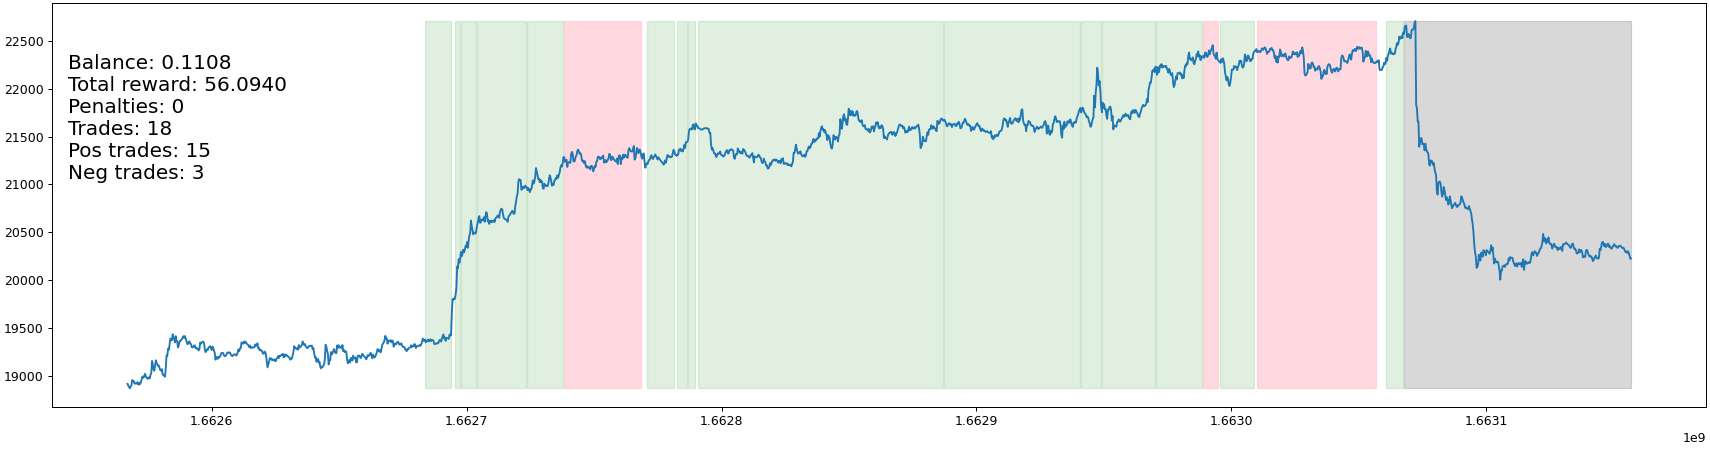

In [44]:
player = Player(env_core, model_test, dpf_test)
result = player.play(fig_size_x = 19, fig_size_y = 5, dpi = 50, font_size = 16)

<IPython.core.display.Javascript object>


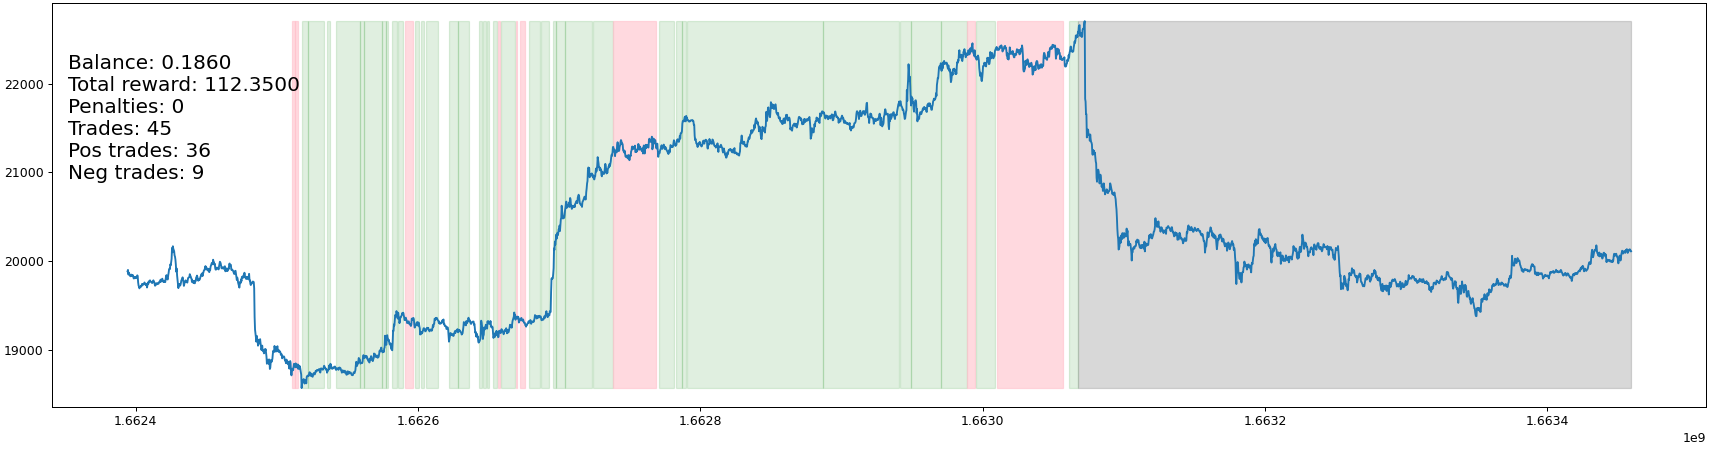

In [51]:
player = Player(env_core, model_test, dpf_test2)
result = player.play(fig_size_x = 19, fig_size_y = 5, dpi = 50, font_size = 16)

<IPython.core.display.Javascript object>


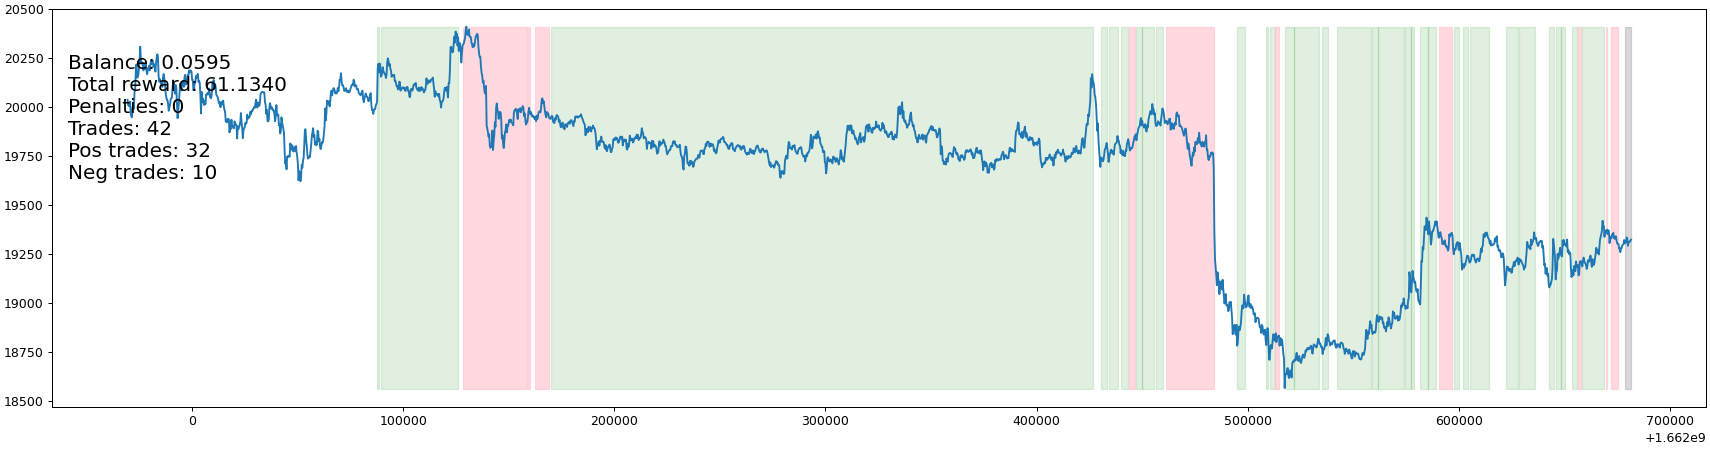

In [52]:
player = Player(env_core, model_test, dpf_test3)
result = player.play(fig_size_x = 19, fig_size_y = 5, dpi = 50, font_size = 16)

# Итоги
 
 - REWARD_SCALE_CLOSE 500 (100 референс) - неожиданно! на train показывал себя хуже всех, однако со временем вышел в стабильный плюс. На тесте самые высокие показатели! Самый большой разрыв по количеству положительных и отрицательных операций. Но есть 2 "НО": 1) на всем интервале есть циклы с неверными действиями. 2) train растет, а test - нет

 - REWARD_SCALE_WAIT = 500 (100 референс) - получает высокую награду, при этом профит в плюс так и не вышел. Самые плохие показатели.

- REWARD_SCALE_OPEN = 100 (10 референс) - На train все неплохо, но на тесте торгует около нуля, тест не растет по мере обучения.

----

Что можно предпринять дальше
1. Исследовать повышенные награды за CLOSE в комбинаци с gamma
2. Попробовать убрать ошибочные действия через повышенный штраф
3. Попробовать 
    - 3.1 вывести признак покупки на более низкий слой
    - 3.2 попробовать более сложную сеть
    
    